In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install supervision
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 56.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-ma

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.6 MB/s eta 0:00:00


In [ ]:
import torch
import supervision as sv
import transformers
import pytorch_lightning

In [ ]:
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.ops import box_convert

from transformers import DetrImageProcessor
image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


In [ ]:
import os
import torchvision

dataset = '/content/drive/MyDrive/dataset'

ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)
TEST_DATASET = CocoDetection(image_directory_path=TEST_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))

loading annotations into memory...
Done (t=1.01s)
creating index...
index created!
loading annotations into memory...
Done (t=2.64s)
creating index...
index created!
loading annotations into memory...
Done (t=2.19s)
creating index...
index created!
Number of training examples: 3631
Number of validation examples: 348
Number of test examples: 169


Image #3378
Annotations found: 1
Image loaded successfully.


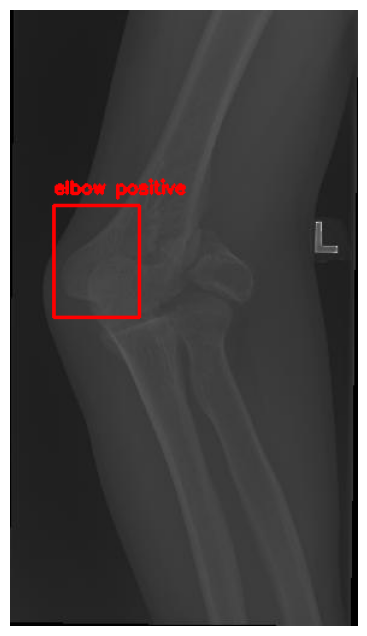

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.loadAnns(TRAIN_DATASET.coco.getAnnIds(imgIds=image_info['id']))

if not annotations:
    print("No annotations for this image.")
else:
    print(f"Annotations found: {len(annotations)}")

image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)
if image is None:
    print("Failed to load image.")
else:
    print("Image loaded successfully.")

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for ann in annotations:
    x, y, width, height = ann['bbox']
    x, y, width, height = int(x), int(y), int(width), int(height)
    cv2.rectangle(image, (x, y), (x + width, y + height), (255, 0, 0), 2)
    category_name = TRAIN_DATASET.coco.cats[ann['category_id']]['name']
    cv2.putText(image, category_name, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)
TEST_DATALOADER = DataLoader(dataset=TEST_DATASET, collate_fn=collate_fn, batch_size=1)

In [ ]:
id2label = {
    1: "elbow positive",
    2: "fingers positive",
    3: "forearm fracture",
    4: "humerus",
    5: "humerus fracture",
    6: "shoulder fracture",
    7: "wrist positive"
}

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):

    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained(
             "facebook/detr-resnet-50",
            num_labels=len(id2label),
            ignore_mismatched_sizes=True
        )

        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):

        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [ ]:
def find_latest_checkpoint(checkpoint_dir):
    checkpoint_files = [os.path.join(checkpoint_dir, f) for f in os.listdir(checkpoint_dir) if f.endswith('.ckpt')]
    if not checkpoint_files:
        return None
    latest_checkpoint = max(checkpoint_files, key=os.path.getctime)
    print(f"Resuming from checkpoint: {latest_checkpoint}")
    return latest_checkpoint

checkpoint_dir = "/content/drive/MyDrive/dataset/checkpoints/"
latest_checkpoint = find_latest_checkpoint(checkpoint_dir)
latest_checkpoint

Resuming from checkpoint: /content/drive/MyDrive/dataset/checkpoints/model-epoch=63.ckpt


'/content/drive/MyDrive/dataset/checkpoints/model-epoch=63.ckpt'

In [ ]:
latest_checkpoint="/content/drive/MyDrive/dataset/checkpoints/model-epoch=49.ckpt"
latest_checkpoint

'/content/drive/MyDrive/dataset/checkpoints/model-epoch=49.ckpt'

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint

MAX_EPOCHS = 65
checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/MyDrive/dataset/checkpoints/",  # Path where the checkpoints will be saved
    filename="model-{epoch:02d}",  # Naming format
    save_top_k=-1,  # Set to a negative value to save all epochs
    every_n_epochs=1,  # Save every epoch
)
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, gradient_clip_val=0.1, accumulate_grad_batches=8, log_every_n_steps=5, callbacks=[checkpoint_callback])

trainer.fit(model, ckpt_path=latest_checkpoint)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/dataset/checkpoints/model-epoch=49.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params
-------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M
-------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.013   Total estimated model params size (MB)
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the chec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=65` reached.


In [ ]:
latest_checkpoint

'/content/drive/MyDrive/dataset/checkpoints/model-epoch=33.ckpt'

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/dataset/checkpoints/custom-model'
model.model.save_pretrained(MODEL_PATH)

In [ ]:
from pytorch_lightning import Trainer

model = Detr.load_from_checkpoint(
    latest_checkpoint,
    lr=1e-4,
    lr_backbone=1e-5,
    weight_decay=1e-4
)


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:

val_dataloader = DataLoader(dataset=VAL_DATASET, batch_size=4, shuffle=False)


In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(devices=1, accelerator="gpu")

result = trainer.validate(model, TRAIN_DATALOADER)
print(result)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric        ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       validation/loss        │     0.47947242856025696      │
│ validation_cardinality_error │      0.3640870153903961      │
│     validation_loss_bbox     │     0.02483379654586315      │
│      validation_loss_ce      │     0.05082133039832115      │
│     validation_loss_giou     │     0.15224115550518036      │
└──────────────────────────────┴──────────────────────────────┘

[{'validation/loss': 0.47947242856025696, 'validation_loss_ce': 0.05082133039832115, 'validation_loss_bbox': 0.02483379654586315, 'validation_loss_giou': 0.15224115550518036, 'validation_cardinality_error': 0.3640870153903961}]


In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(devices=1, accelerator="gpu")

result = trainer.validate(model, VAL_DATALOADER)
print(result)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric        ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       validation/loss        │      1.4056905508041382      │
│ validation_cardinality_error │      0.4568965435028076      │
│     validation_loss_bbox     │     0.08251330256462097      │
│      validation_loss_ce      │      0.2321612536907196      │
│     validation_loss_giou     │      0.3804813623428345      │
└──────────────────────────────┴──────────────────────────────┘

[{'validation/loss': 1.4056905508041382, 'validation_loss_ce': 0.2321612536907196, 'validation_loss_bbox': 0.08251330256462097, 'validation_loss_giou': 0.3804813623428345, 'validation_cardinality_error': 0.4568965435028076}]


In [ ]:
from pytorch_lightning import Trainer

trainer = Trainer(devices=1, accelerator="gpu")

result = trainer.validate(model, TEST_DATALOADER)
print(result)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Validate metric        ┃         DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       validation/loss        │      1.5155158042907715      │
│ validation_cardinality_error │     0.48520711064338684      │
│     validation_loss_bbox     │     0.08811526745557785      │
│      validation_loss_ce      │      0.2341357171535492      │
│     validation_loss_giou     │     0.42040181159973145      │
└──────────────────────────────┴──────────────────────────────┘

[{'validation/loss': 1.5155158042907715, 'validation_loss_ce': 0.2341357171535492, 'validation_loss_bbox': 0.08811526745557785, 'validation_loss_giou': 0.42040181159973145, 'validation_cardinality_error': 0.48520711064338684}]


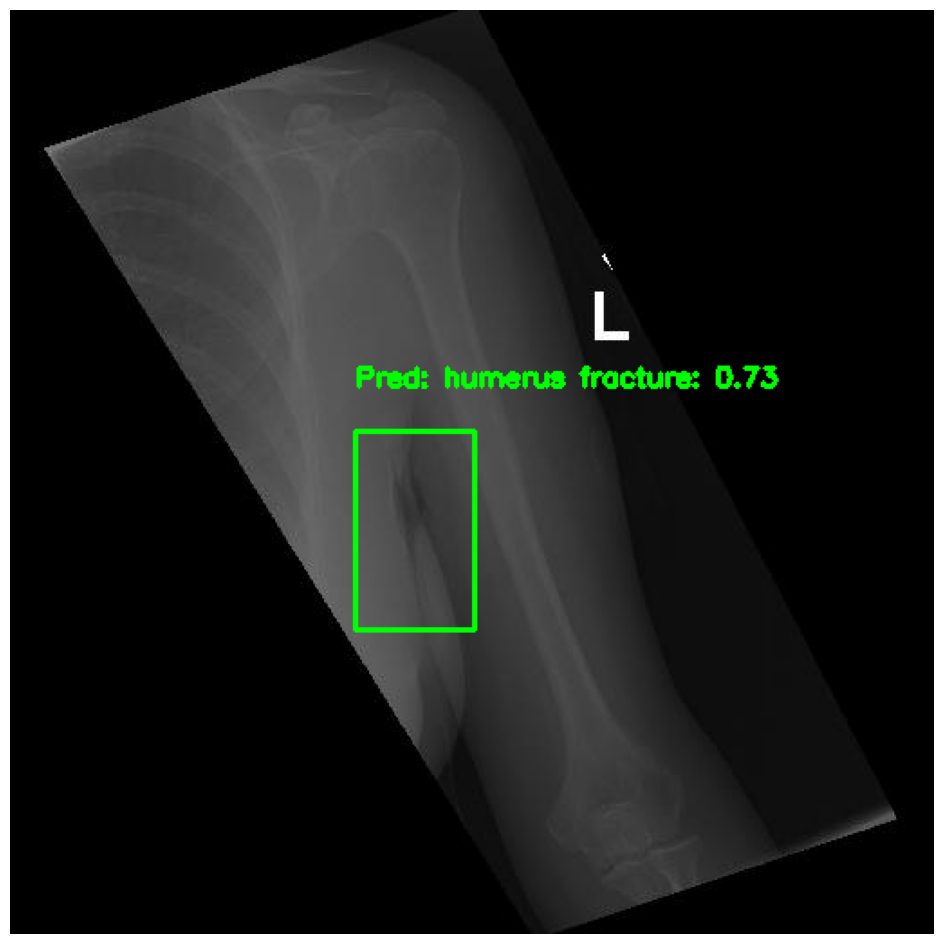

In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

image_ids = TEST_DATASET.coco.getImgIds()
image_id = np.random.choice(image_ids)
image_info = TEST_DATASET.coco.loadImgs([image_id])[0]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = Image.open(image_path)
inputs = image_processor(images=image, return_tensors="pt")

inputs = {k: v.to('cuda') for k, v in inputs.items()}
outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

image_np = np.array(image)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

annotations = TEST_DATASET.coco.loadAnns(TEST_DATASET.coco.getAnnIds(imgIds=[image_id]))
for ann in annotations:
    x, y, width, height = map(int, ann['bbox'])
    cv2.rectangle(image_np, (x, y), (x + width, y + height), (255, 0, 0), 4)
    category_name = TEST_DATASET.coco.cats[ann['category_id']]['name']
    cv2.putText(image_np, f"GT: {category_name}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = box.cpu().int().numpy()
    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2, lineType=cv2.LINE_4, shift=0)
    label_with_score = f"{id2label[label.item()]}: {score.item():.2f}"
    cv2.putText(image_np, f"Pred: {label_with_score}", (box[0], box[1] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


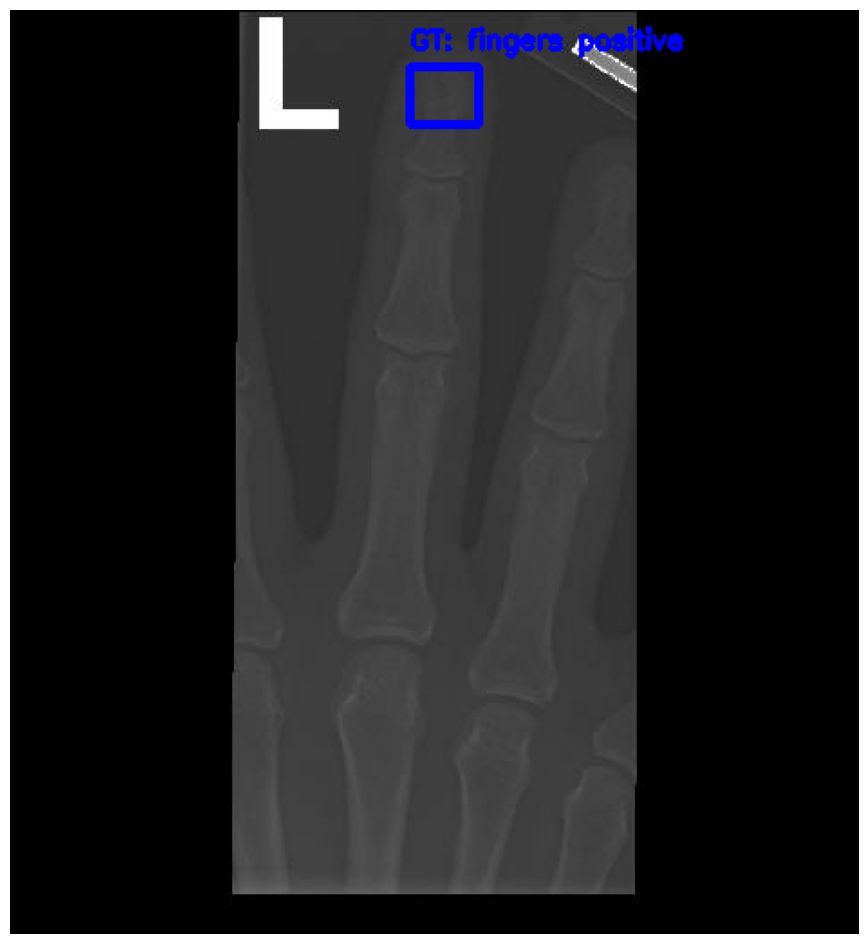

In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

image_ids = TEST_DATASET.coco.getImgIds()
image_id = np.random.choice(image_ids)
image_info = TEST_DATASET.coco.loadImgs([image_id])[0]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = Image.open(image_path)
inputs = image_processor(images=image, return_tensors="pt")

inputs = {k: v.to('cuda') for k, v in inputs.items()}
outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

image_np = np.array(image)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

annotations = TEST_DATASET.coco.loadAnns(TEST_DATASET.coco.getAnnIds(imgIds=[image_id]))
for ann in annotations:
    x, y, width, height = map(int, ann['bbox'])
    cv2.rectangle(image_np, (x, y), (x + width, y + height), (255, 0, 0), 4)
    category_name = TEST_DATASET.coco.cats[ann['category_id']]['name']
    cv2.putText(image_np, f"GT: {category_name}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = box.cpu().int().numpy()
    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2, lineType=cv2.LINE_4, shift=0)
    label_with_score = f"{id2label[label.item()]}: {score.item():.2f}"
    cv2.putText(image_np, f"Pred: {label_with_score}", (box[0], box[1] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


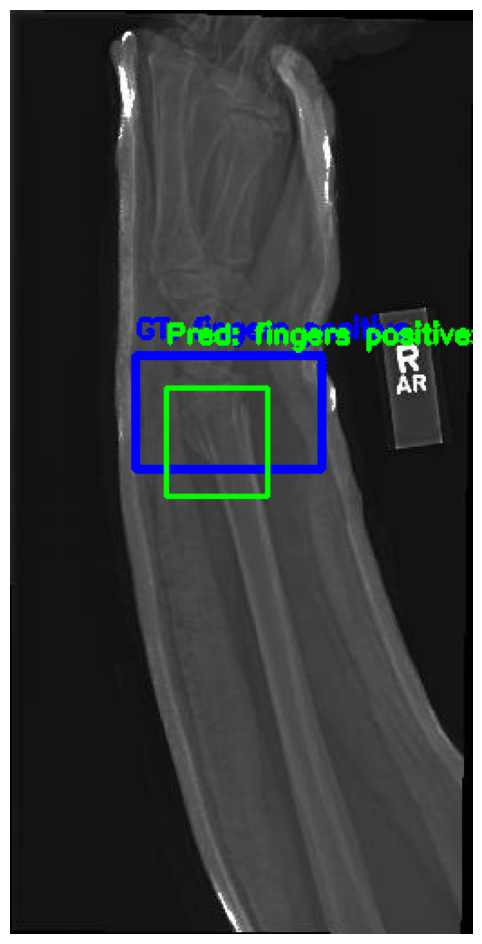

In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

image_ids = TEST_DATASET.coco.getImgIds()
image_id = np.random.choice(image_ids)
image_info = TEST_DATASET.coco.loadImgs([image_id])[0]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = Image.open(image_path)
inputs = image_processor(images=image, return_tensors="pt")

inputs = {k: v.to('cuda') for k, v in inputs.items()}
outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]
image_np = np.array(image)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


annotations = TEST_DATASET.coco.loadAnns(TEST_DATASET.coco.getAnnIds(imgIds=[image_id]))
for ann in annotations:
    x, y, width, height = map(int, ann['bbox'])
    cv2.rectangle(image_np, (x, y), (x + width, y + height), (255, 0, 0), 4)
    category_name = TEST_DATASET.coco.cats[ann['category_id']]['name']
    cv2.putText(image_np, f"GT: {category_name}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = box.cpu().int().numpy()
    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2, lineType=cv2.LINE_4, shift=0)
    label_with_score = f"{id2label[label.item()]}: {score.item():.2f}"
    cv2.putText(image_np, f"Pred: {label_with_score}", (box[0], box[1] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


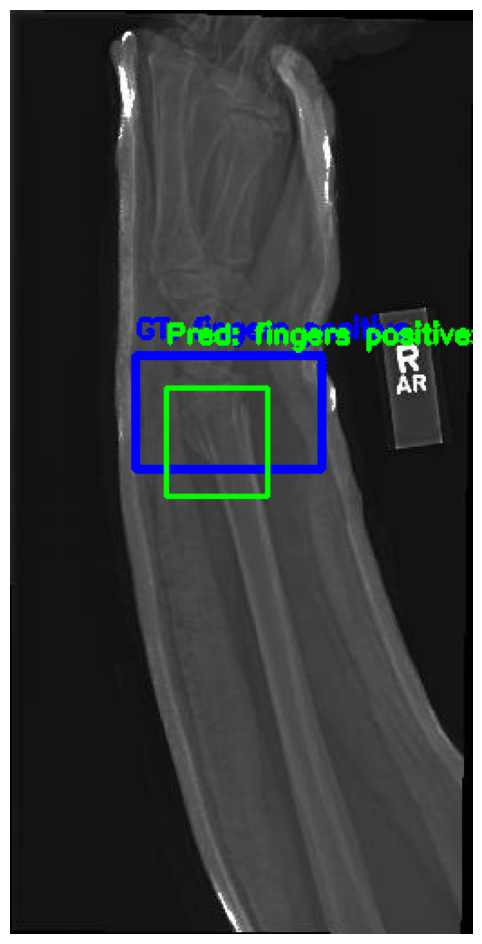

In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2


image_ids = TEST_DATASET.coco.getImgIds()
image_id = np.random.choice(image_ids)
image_info = TEST_DATASET.coco.loadImgs([image_id])[0]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = Image.open(image_path)
inputs = image_processor(images=image, return_tensors="pt")


inputs = {k: v.to('cuda') for k, v in inputs.items()}
outputs = model(**inputs)

target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

image_np = np.array(image)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

annotations = TEST_DATASET.coco.loadAnns(TEST_DATASET.coco.getAnnIds(imgIds=[image_id]))
for ann in annotations:
    x, y, width, height = map(int, ann['bbox'])
    cv2.rectangle(image_np, (x, y), (x + width, y + height), (255, 0, 0), 4)
    category_name = TEST_DATASET.coco.cats[ann['category_id']]['name']
    cv2.putText(image_np, f"GT: {category_name}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = box.cpu().int().numpy()
    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2, lineType=cv2.LINE_4, shift=0)
    label_with_score = f"{id2label[label.item()]}: {score.item():.2f}"
    cv2.putText(image_np, f"Pred: {label_with_score}", (box[0], box[1] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


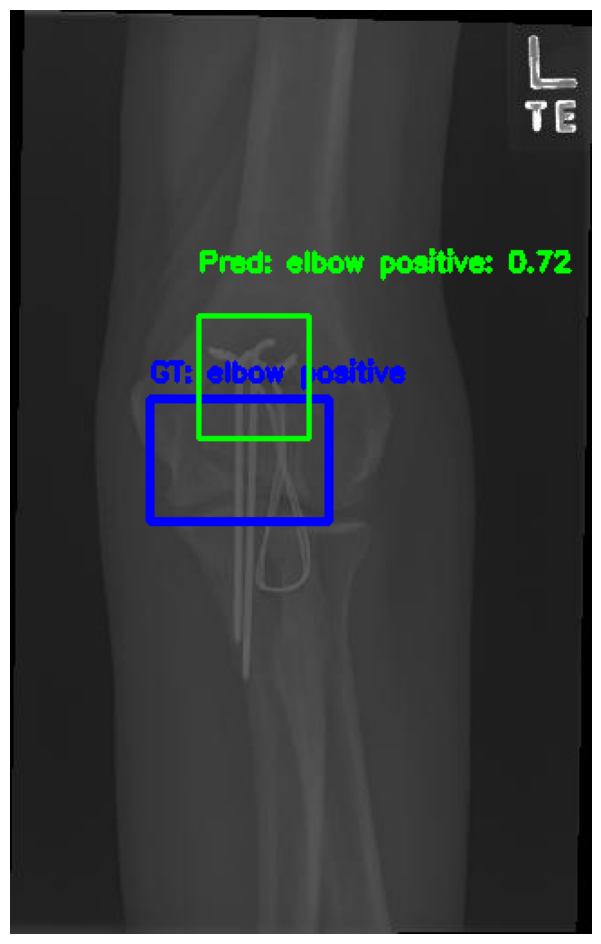

In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2



image_ids = TEST_DATASET.coco.getImgIds()
image_id = np.random.choice(image_ids)
image_info = TEST_DATASET.coco.loadImgs([image_id])[0]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = Image.open(image_path)
inputs = image_processor(images=image, return_tensors="pt")


inputs = {k: v.to('cuda') for k, v in inputs.items()}
outputs = model(**inputs)


target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]


image_np = np.array(image)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


annotations = TEST_DATASET.coco.loadAnns(TEST_DATASET.coco.getAnnIds(imgIds=[image_id]))
for ann in annotations:
    x, y, width, height = map(int, ann['bbox'])
    cv2.rectangle(image_np, (x, y), (x + width, y + height), (255, 0, 0), 4)
    category_name = TEST_DATASET.coco.cats[ann['category_id']]['name']
    cv2.putText(image_np, f"GT: {category_name}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = box.cpu().int().numpy()
    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2, lineType=cv2.LINE_4, shift=0)
    label_with_score = f"{id2label[label.item()]}: {score.item():.2f}"
    cv2.putText(image_np, f"Pred: {label_with_score}", (box[0], box[1] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


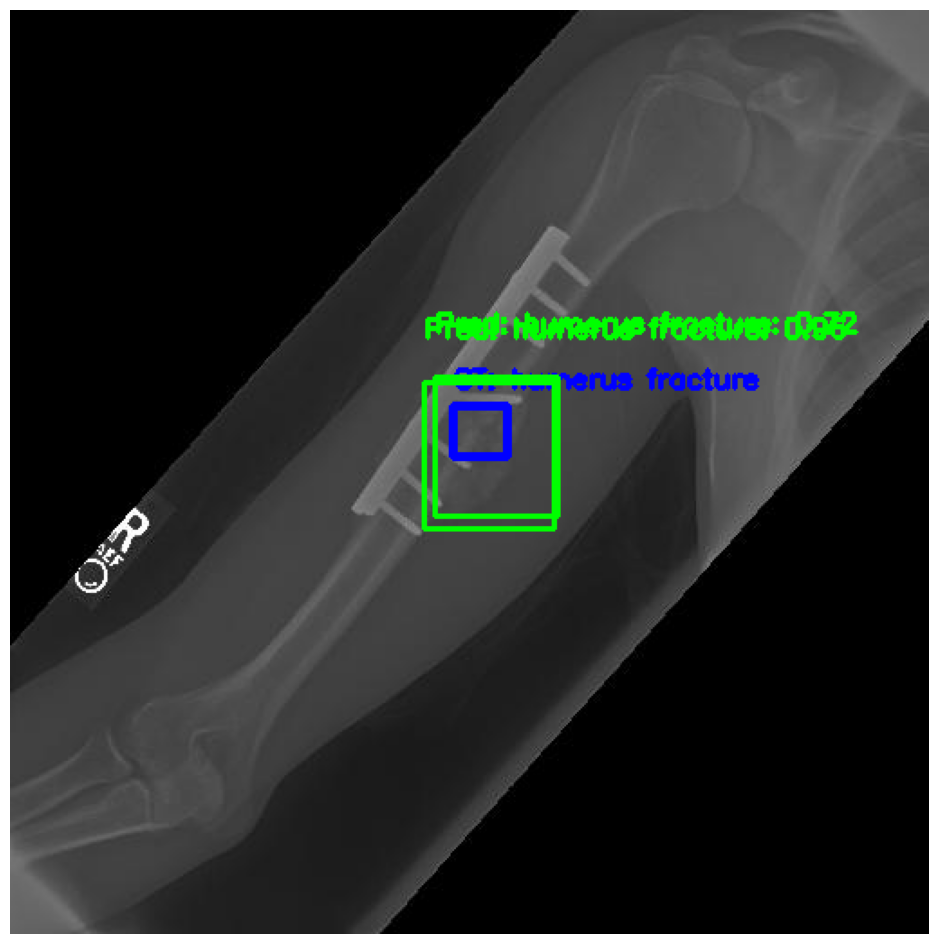

In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2



image_ids = TEST_DATASET.coco.getImgIds()
image_id = np.random.choice(image_ids)
image_info = TEST_DATASET.coco.loadImgs([image_id])[0]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = Image.open(image_path)
inputs = image_processor(images=image, return_tensors="pt")


inputs = {k: v.to('cuda') for k, v in inputs.items()}
outputs = model(**inputs)


target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]


image_np = np.array(image)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


annotations = TEST_DATASET.coco.loadAnns(TEST_DATASET.coco.getAnnIds(imgIds=[image_id]))
for ann in annotations:
    x, y, width, height = map(int, ann['bbox'])
    cv2.rectangle(image_np, (x, y), (x + width, y + height), (255, 0, 0), 4)
    category_name = TEST_DATASET.coco.cats[ann['category_id']]['name']
    cv2.putText(image_np, f"GT: {category_name}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = box.cpu().int().numpy()
    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2, lineType=cv2.LINE_4, shift=0)
    label_with_score = f"{id2label[label.item()]}: {score.item():.2f}"
    cv2.putText(image_np, f"Pred: {label_with_score}", (box[0], box[1] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


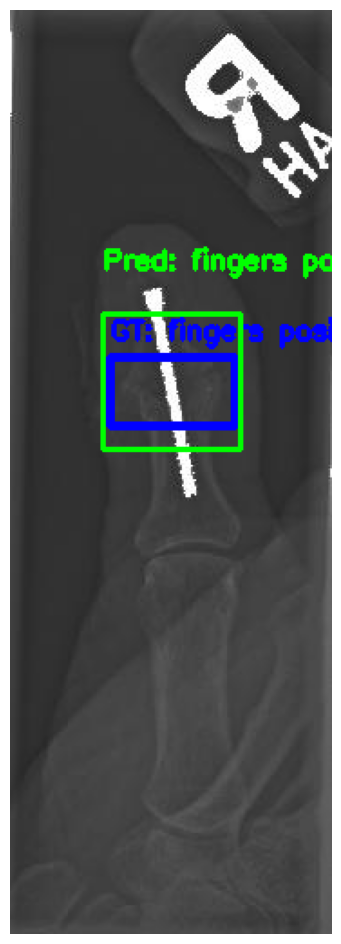

In [ ]:
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2



image_ids = TEST_DATASET.coco.getImgIds()
image_id = np.random.choice(image_ids)
image_info = TEST_DATASET.coco.loadImgs([image_id])[0]
image_path = os.path.join(TEST_DATASET.root, image_info['file_name'])
image = Image.open(image_path)
inputs = image_processor(images=image, return_tensors="pt")


inputs = {k: v.to('cuda') for k, v in inputs.items()}
outputs = model(**inputs)


target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]


image_np = np.array(image)
image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)


annotations = TEST_DATASET.coco.loadAnns(TEST_DATASET.coco.getAnnIds(imgIds=[image_id]))
for ann in annotations:
    x, y, width, height = map(int, ann['bbox'])
    cv2.rectangle(image_np, (x, y), (x + width, y + height), (255, 0, 0), 4)
    category_name = TEST_DATASET.coco.cats[ann['category_id']]['name']
    cv2.putText(image_np, f"GT: {category_name}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)


for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = box.cpu().int().numpy()
    cv2.rectangle(image_np, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2, lineType=cv2.LINE_4, shift=0)
    label_with_score = f"{id2label[label.item()]}: {score.item():.2f}"
    cv2.putText(image_np, f"Pred: {label_with_score}", (box[0], box[1] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
